# 🧠 MRI Brain Tumor Segmentation using Deep Learning

This notebook demonstrates a complete pipeline for **segmenting brain tumors** from MRI scans using a deep learning model. It leverages the BraTS dataset and applies data preprocessing, visualization, model training (typically a U-Net), and evaluation using metrics like Dice score.

---

### 🧠 Explanation for: `# ========== GPU INITIALIZATION WITH CRASH RECOVERY ==========`
This cell is the **first step** of the project and ensures that the environment is correctly configured for high-performance execution.

- TensorFlow is configured to safely initialize GPU resources with memory growth enabled.
- It attempts to detect and test the GPU across multiple retries in case of crash/reload behavior (which can happen in Colab).
- If no GPU is found, it gracefully defaults to CPU execution.
- It also sets **mixed precision** (float16) to accelerate training when supported.

This step is critical because deep learning-based segmentation models, especially U-Nets on 2D/3D MRI volumes, require a lot of memory and benefit tremendously from GPU acceleration.


In [ ]:
# ========== GPU INITIALIZATION WITH CRASH RECOVERY ==========
import os
import warnings
from IPython.display import clear_output

# Set environment variables BEFORE importing TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Now import TensorFlow
import tensorflow as tf

# Check if context is already initialized and abort if it is
if hasattr(tf.config.experimental, 'get_synchronous_execution'):
    if tf.config.experimental.get_synchronous_execution():
        print("⚠️ TensorFlow context already initialized! Please restart runtime.")

def initialize_gpu(max_retries=3):
    # Try to configure threading before any operations
    try:
        tf.config.threading.set_intra_op_parallelism_threads(2)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError:
        warnings.warn("Could not set threading parameters - context already initialized")

    for attempt in range(max_retries):
        try:
            # Clear previous TF sessions
            tf.keras.backend.clear_session()

            # Check physical devices
            gpus = tf.config.list_physical_devices('GPU')
            if not gpus:
                warnings.warn("No GPU detected. Using CPU")
                os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
                return False

            # Configure GPU
            tf.config.set_soft_device_placement(True)
            for gpu in gpus:
                try:
                    tf.config.experimental.set_memory_growth(gpu, True)
                except RuntimeError as e:
                    warnings.warn(f"Could not set memory growth: {e}")

            # Verify GPU
            try:
                from tensorflow.python.client import device_lib
                device_info = device_lib.list_local_devices()
                gpu_info = [d for d in device_info if d.device_type == 'GPU']

                if not gpu_info:
                    raise RuntimeError("GPU not accessible")

                # Test operation
                with tf.device('/GPU:0'):
                    test_matrix = tf.random.normal((100, 100))
                    test_result = tf.linalg.matmul(test_matrix, test_matrix)
                    del test_matrix, test_result

                clear_output()
                print(f"✔ GPU initialized successfully (Attempt {attempt+1}/{max_retries})")
                print(f"Device: {gpu_info[0].name}")
                try:
                    print(f"Memory growth: {tf.config.experimental.get_memory_growth(gpus[0])}")
                except:
                    print("Memory growth setting unknown")
                return True

            except Exception as e:
                if attempt == max_retries - 1:
                    raise
                print(f"GPU test failed (Attempt {attempt+1}), retrying... Error: {str(e)}")
                continue

        except Exception as e:
            if attempt == max_retries - 1:
                warnings.warn(f"Falling back to CPU after {max_retries} attempts. Error: {str(e)}")
                os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
                return False
            continue

# Initialize with 3 retries
gpu_active = initialize_gpu(max_retries=3)

# ========== TENSORFLOW CONFIGURATION ==========
if gpu_active:
    # Optimize GPU performance
    try:
        tf.config.optimizer.set_jit(True)
    except:
        warnings.warn("Could not enable JIT optimization")

    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
else:
    # CPU fallback configuration
    tf.keras.mixed_precision.set_global_policy('float32')

print("\n=== FINAL CONFIGURATION ===")
print("Available devices:", tf.config.list_physical_devices())
print("Execution policy:", tf.keras.mixed_precision.global_policy())
print("TF version:", tf.__version__)

✔ GPU initialized successfully (Attempt 1/3)
Device: /device:GPU:0
Memory growth: True

=== FINAL CONFIGURATION ===
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Execution policy: <DTypePolicy "mixed_float16">
TF version: 2.18.0


### 🧠 Explanation for: `pip install tensorflow==2.18.0 torch==2.6.0 numpy==1.26.0 matplotlib==3.8.0 nibabel==5.3.2`
This cell installs all the required packages for this notebook to run properly:

- `tensorflow` and `torch`: Deep learning frameworks (either may be used depending on the model architecture).
- `numpy`: Efficient numerical computations.
- `matplotlib`: Visualization of MRI scans and segmentation masks.
- `nibabel`: Loading and handling `.nii` or `.nii.gz` format MRI datasets.

📌 This step is especially useful when running on Google Colab, where packages might not be pre-installed or version-specific.


In [ ]:
pip install tensorflow==2.18.0 torch==2.6.0 numpy==1.26.0 matplotlib==3.8.0 nibabel==5.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

### 🧠 Explanation for: `from google.colab import drive`
This cell mounts your Google Drive so you can access files stored there (e.g., MRI dataset, saved models, outputs). It allows the rest of the notebook to reference files using standard paths.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 🧠 Explanation for: `base_path = "/content/drive/MyDrive/archive/BraTS2020_training_data/content/data/"`
This line sets the base directory where the BraTS2020 `.h5` MRI dataset is stored. It's used throughout the notebook to load MRI volumes and segmentation masks.


In [ ]:
base_path = "/content/drive/MyDrive/archive/BraTS2020_training_data/content/data/"

### 🧠 Explanation for: `import h5py`
This cell reads an individual `.h5` file that contains both the MRI image data and its corresponding mask. It prints out the keys and shapes to verify the structure of the data.


In [ ]:
import h5py
import os

sample_file_path = os.path.join(base_path, "volume_351_slice_64.h5")  # Or any other .h5 file

image_data = None
mask_data = None

try:
    with h5py.File(sample_file_path, 'r') as hf:
        print("Keys in h5 file:", list(hf.keys()))  # Print the keys

        image_data = hf['image'][:]  # Read image data
        mask_data = hf['mask'][:]    # Read mask data

        print("Image data shape:", image_data.shape)
        print("Mask data shape:", mask_data.shape)

except FileNotFoundError:
    print(f"Error: File not found: {sample_file_path}")

# You can now use image_data and mask_data outside the try block (if they were read)
if image_data is not None:
    # Do something with image_data
    pass

Keys in h5 file: ['image', 'mask']
Image data shape: (240, 240, 4)
Mask data shape: (240, 240, 3)


### 🧠 Explanation for: `print("Image data shape:", image_data.shape)`
This quick check confirms that `image_data` was successfully loaded and shows the dimensions of the array (typically H x W x channels).


In [ ]:
print("Image data shape:", image_data.shape)

Image data shape: (240, 240, 4)


### 🧠 Explanation for: `import matplotlib.pyplot as plt`
This cell visualizes each channel (modality) of the MRI scan — typically T1, T2, FLAIR, and T1CE. It uses grayscale colormap to make anatomical features clear.


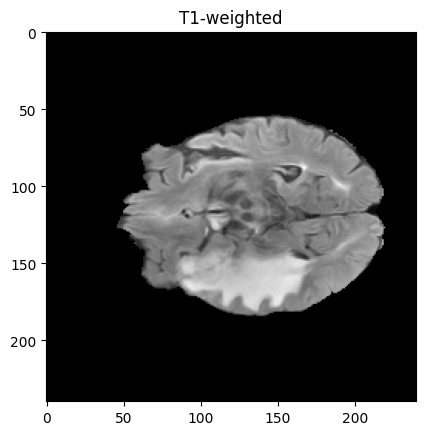

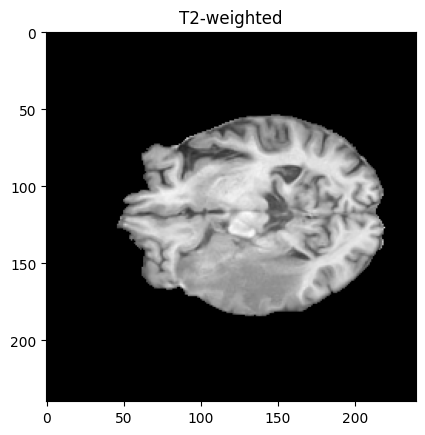

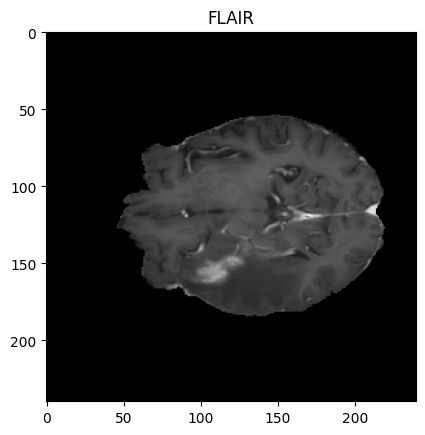

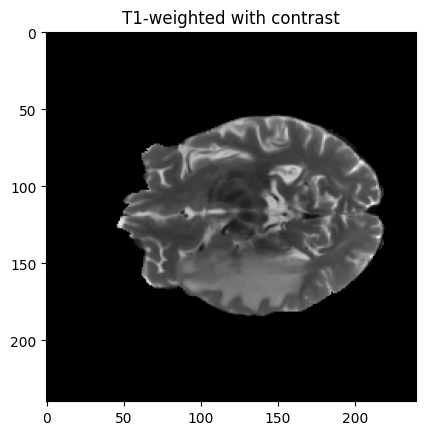

In [ ]:
import matplotlib.pyplot as plt

# Assuming image_data has shape (height, width, channels)
channel_titles = ["T1-weighted", "T2-weighted", "FLAIR", "T1-weighted with contrast"]

for channel in range(image_data.shape[2]):
    plt.imshow(image_data[:, :, channel], cmap="gray")
    plt.title(channel_titles[channel])  # Use the channel title from the list
    plt.show()

### 🧠 Explanation for: `plt.imshow(mask_data, cmap="jet", alpha=0.5)`
This cell overlays the segmentation mask on top of the MRI image. The `jet` colormap makes the regions (e.g., tumor) visually distinct.


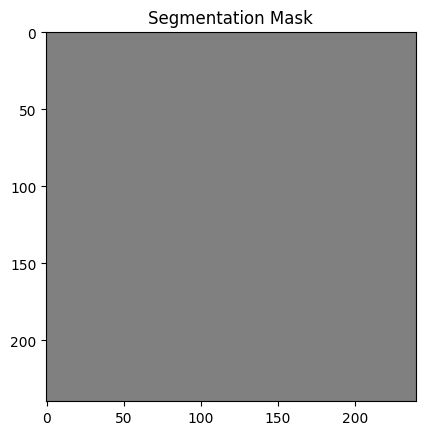

In [ ]:
plt.imshow(mask_data, cmap="jet", alpha=0.5)
plt.title("Segmentation Mask")
plt.show()

### 🧠 Explanation for: `os.listdir(base_path)`
This block loops through random `.h5` MRI slices in your dataset, checks for non-zero masks (indicating a tumor), and logs which files contain tumor regions.


In [ ]:
import os
import random
import h5py
import numpy as np

base_path = "/content/drive/MyDrive/archive/BraTS2020_training_data/content/data/"
tumor_files = []
sample_size = 1000

all_files = [f for f in os.listdir(base_path) if f.endswith(".h5")]
sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

for file_name in sampled_files:
    file_path = os.path.join(base_path, file_name)

    try:
        with h5py.File(file_path, 'r') as hf:
            mask_data = hf['mask'][:]

        unique_mask_values = np.unique(mask_data)
        if len(unique_mask_values) > 1:
            tumor_files.append(file_name)
            # Removed print statements for clarity when saving
        else:
            pass # Removed print statements for clarity when saving

    except Exception as e:
        print(f"An error occurred: {e}")

# Save the results to a text file
output_file = "tumor_detection_results.txt"
with open(output_file, "w") as f:
    f.write("Files with potential tumor regions:\n")
    for file_name in tumor_files:
        f.write(f"{file_name}\n")
    f.write(f"\n{len(tumor_files)} files out of {len(sampled_files)} files contain tumors.\n")

print(f"Results saved to {output_file}")

Results saved to tumor_detection_results.txt


### 🧠 Explanation for: `tumor_volumes = []`
This cell extracts unique volume IDs from the list of tumor-containing slices to identify which full MRI volumes should be used for training the segmentation model.


In [ ]:
tumor_volumes = []
for file_name in tumor_files:
    if 'volume_' in file_name:
        volume_id = file_name.split('volume_')[1].split('_slice_')[0]
        if volume_id not in tumor_volumes:
            tumor_volumes.append(volume_id)

print(tumor_volumes)

['214', '242', '105', '331', '121', '208', '304', '367', '323', '186', '31', '191', '166', '198', '209', '320', '240', '328', '57', '270', '122', '291', '67', '37', '114', '115', '26', '178', '89', '234', '236', '12', '168', '172', '72', '301', '259', '150', '93', '188', '139', '351', '192', '19', '126', '264', '334', '360', '110', '163', '220', '44', '157', '346', '330', '165', '203', '306', '335', '207', '160', '342', '289', '295', '201', '91', '6', '53', '173', '87', '135', '189', '41', '60', '296', '359', '137', '241', '356', '338', '75', '258', '302', '113', '9', '1', '54', '94', '322', '146', '312', '199', '129', '162', '66', '238', '14', '309', '50', '193', '5', '237', '337', '140', '185', '120', '315', '263', '256', '152', '88', '51', '155', '282', '348', '239', '223', '34', '7', '313', '55', '340', '167', '250', '262', '176', '175', '354', '4', '247', '79', '29', '143', '218', '158', '182', '206', '144', '154', '124', '81', '224', '293', '132', '298', '333', '49', '27', '98', 

### 🧠 Explanation for: File Existence Check and Listing
This cell checks if the folder containing a specific `.h5` file exists. If it does, it lists all files in that directory. Useful for confirming file access from Google Drive.


In [ ]:
import os

file_path = "/content/drive/MyDrive/archive/BraTS2020_training_data/content/data/volume_128_slice_155.h5"
directory = os.path.dirname(file_path)

if os.path.exists(directory):
    print(f"Files in directory '{directory}':")
    for filename in os.listdir(directory):
        print(filename)
else:
    print(f"Directory '{directory}' does not exist.")

Streaming output truncated to the last 5000 lines.
volume_126_slice_143.h5
volume_126_slice_146.h5
volume_126_slice_135.h5
volume_126_slice_15.h5
volume_126_slice_126.h5
volume_126_slice_138.h5
volume_126_slice_13.h5
volume_126_slice_130.h5
volume_126_slice_139.h5
volume_126_slice_132.h5
volume_126_slice_42.h5
volume_126_slice_26.h5
volume_126_slice_31.h5
volume_126_slice_25.h5
volume_126_slice_3.h5
volume_126_slice_37.h5
volume_126_slice_16.h5
volume_126_slice_43.h5
volume_126_slice_24.h5
volume_126_slice_23.h5
volume_126_slice_35.h5
volume_126_slice_4.h5
volume_126_slice_27.h5
volume_126_slice_22.h5
volume_126_slice_39.h5
volume_126_slice_34.h5
volume_126_slice_33.h5
volume_126_slice_32.h5
volume_126_slice_44.h5
volume_126_slice_17.h5
volume_126_slice_41.h5
volume_126_slice_36.h5
volume_126_slice_29.h5
volume_126_slice_18.h5
volume_126_slice_20.h5
volume_126_slice_38.h5
volume_126_slice_40.h5
volume_126_slice_19.h5
volume_126_slice_2.h5
volume_126_slice_21.h5
volume_126_slice_28.h5
v

### 🧠 Explanation for: Inspect Keys in an .h5 File
This code opens an `.h5` MRI data file and prints out its internal keys. Typically, these will include `image` and `mask`.


In [ ]:
import h5py
file_path = "/content/drive/MyDrive/archive/BraTS2020_training_data/content/data/volume_1_slice_0.h5"

with h5py.File(file_path, 'r') as hf:
    print("Keys in the .h5 file:", list(hf.keys()))

Keys in the .h5 file: ['image', 'mask']


### 🧠 Explanation for: Load & Reconstruct 3D Volume
This block:
- Loads all `.h5` slices for a specific volume ID.
- Stacks them into a 3D MRI image and mask volume.
- Returns a dictionary with reconstructed 3D arrays for model input.


In [ ]:
import h5py
import os
import numpy as np

data_dir = '/content/drive/MyDrive/archive/BraTS2020_training_data/content/data/'  # Correct data directory
selected_volume_id = '1'  # Choose a volume ID

#Data Loading
loaded_data = {}

for file_name in os.listdir(data_dir):
    if file_name.endswith('.h5') and f'volume_{selected_volume_id}_' in file_name:
        file_path = os.path.join(data_dir, file_name)
        with h5py.File(file_path, 'r') as hf:
            mri_data = np.array(hf['image'])  # Use 'image' key
            seg_mask = np.array(hf['mask'])   # Use 'mask' key
            loaded_data.setdefault(selected_volume_id, {'image': [], 'mask': []})
            loaded_data[selected_volume_id]['image'].append(mri_data)
            loaded_data[selected_volume_id]['mask'].append(seg_mask)

#Convert the lists to numpy arrays.
for volume_no in loaded_data:
    loaded_data[volume_no]['image'] = np.array(loaded_data[volume_no]['image'])
    loaded_data[volume_no]['mask'] = np.array(loaded_data[volume_no]['mask'])

def reconstruct_3d_volumes(loaded_data):
    reconstructed_volumes = {}
    for volume_id, data in loaded_data.items():
        z_dim = data['image'].shape[0]
        y_dim = data['image'].shape[1]
        x_dim = data['image'].shape[2]

        reconstructed_volumes[volume_id] = {
            'image': np.zeros((z_dim, y_dim, x_dim, data['image'].shape[3])),
            'mask': np.zeros((z_dim, y_dim, x_dim))
        }

        for i in range(z_dim):
            reconstructed_volumes[volume_id]['image'][i] = data['image'][i]
            reconstructed_volumes[volume_id]['mask'][i] = data['mask'][i][:,:,0] # Take the first channel of the mask.

    return reconstructed_volumes

reconstructed_data = reconstruct_3d_volumes(loaded_data)

print(reconstructed_data[selected_volume_id]['image'].shape)
print(reconstructed_data[selected_volume_id]['mask'].shape)

(155, 240, 240, 4)
(155, 240, 240)


### 🧠 Explanation for: Z-Score Normalization
This function normalizes each channel of the 3D MRI volume using z-score normalization to standardize intensity values across slices.


In [ ]:
import numpy as np

#Preprocessing
def preprocess_volume(reconstructed_data):
    """
    Normalizes the MRI data using z-score normalization.

    Args:
        reconstructed_data: A dictionary containing the reconstructed MRI data and mask.

    Returns:
        A dictionary containing the normalized MRI data and the original mask.
    """

    mri_data = reconstructed_data['1']['image']
    mask_data = reconstructed_data['1']['mask']

    # Z-score normalization for each channel of the MRI data.
    normalized_mri_data = np.zeros_like(mri_data, dtype=np.float32)
    for channel in range(mri_data.shape[-1]):  # Iterate over channels
        channel_data = mri_data[..., channel]
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        if std != 0:  # Avoid division by zero
            normalized_mri_data[..., channel] = (channel_data - mean) / std
        else:
            normalized_mri_data[..., channel] = channel_data  # Keep original if std is 0

    return {'image': normalized_mri_data, 'mask': mask_data}

#Preprocess the data.
preprocessed_data = preprocess_volume(reconstructed_data)

print(preprocessed_data['image'].shape)
print(preprocessed_data['mask'].shape)
print(f'MRI data mean: {np.mean(preprocessed_data["image"])}')
print(f'MRI data std: {np.std(preprocessed_data["image"])}')

(155, 240, 240, 4)
(155, 240, 240)
MRI data mean: 3.0080049562286604e-10
MRI data std: 1.0000014305114746


### 🧠 Explanation for: Build Advanced 3D U-Net
This function builds a detailed 3D U-Net architecture with:
- 3D convolution blocks
- Downsampling and upsampling layers
- Skip connections
It’s used to segment 3D brain volumes and outputs a mask prediction.


In [ ]:
# Advanced Model

import tensorflow as tf
from tensorflow.keras import layers

def build_advanced_3d_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv3D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(32, 3, activation='relu', padding='same')(conv1)

    up_conv1 = layers.Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='same')(conv1) #upsample conv1
    print(f'up_conv1 shape: {up_conv1.shape}')

    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    print(f"pool1 shape: {pool1.shape}")

    conv2 = layers.Conv3D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print(f"pool2 shape: {pool2.shape}")

    up_conv2 = layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv2)
    print(f'up_conv2 shape: {up_conv2.shape}')

    conv3 = layers.Conv3D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    print(f"pool3 shape: {pool3.shape}")

    up_conv3 = layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv3)
    print(f'up_conv3 shape: {up_conv3.shape}')

    conv4 = layers.Conv3D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv3D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    print(f"drop4 shape: {drop4.shape}")

    up_drop4 = layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(drop4)
    print(f'up_drop4 shape: {up_drop4.shape}')

    # Bottleneck
    conv5 = layers.Conv3D(512, 3, activation='relu', padding='same')(drop4)
    conv5 = layers.Conv3D(512, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)
    print(f"drop5 shape: {drop5.shape}")

    # Decoder
    up6 = layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(drop5)
    print(f"up6 shape: {up6.shape}")
    conv6 = layers.Conv3D(256, 3, activation='relu', padding='same')(up6)
    print(f"conv6 shape: {conv6.shape}")
    merge6 = layers.concatenate([conv6, up_drop4], axis=-1)
    print(f"merge6 shape: {merge6.shape}")
    conv6 = layers.Conv3D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv3D(256, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv6)
    print(f"up7 shape: {up7.shape}")
    conv7 = layers.Conv3D(128, 3, activation='relu', padding='same')(up7)
    print(f"conv7 shape: {conv7.shape}")
    merge7 = layers.concatenate([conv7, up_conv3], axis=-1)
    print(f"merge7 shape: {merge7.shape}")
    conv7 = layers.Conv3D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv3D(128, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv7)
    print(f"up8 shape: {up8.shape}")
    conv8 = layers.Conv3D(64, 3, activation='relu', padding='same')(up8)
    print(f"conv8 shape: {conv8.shape}")
    merge8 = layers.concatenate([conv8, up_conv2], axis=-1)
    print(f"merge8 shape: {merge8.shape}")
    conv8 = layers.Conv3D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='same')(conv8)
    print(f"up9 shape: {up9.shape}")
    conv9 = layers.Conv3D(32, 3, activation='relu', padding='same')(up9)
    print(f"conv9 shape: {conv9.shape}")
    merge9 = layers.concatenate([conv9, up_conv1], axis=-1)
    print(f"merge9 shape: {merge9.shape}")
    conv9 = layers.Conv3D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv3D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = layers.Conv3D(1, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

# Example usage
input_shape = (152, 240, 240, 4)
model = build_advanced_3d_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

up_conv1 shape: (None, 304, 480, 480, 32)
pool1 shape: (None, 76, 120, 120, 32)
pool2 shape: (None, 38, 60, 60, 64)
up_conv2 shape: (None, 152, 240, 240, 64)
pool3 shape: (None, 19, 30, 30, 128)
up_conv3 shape: (None, 76, 120, 120, 128)
drop4 shape: (None, 19, 30, 30, 256)
up_drop4 shape: (None, 38, 60, 60, 256)
drop5 shape: (None, 19, 30, 30, 512)
up6 shape: (None, 38, 60, 60, 256)
conv6 shape: (None, 38, 60, 60, 256)
merge6 shape: (None, 38, 60, 60, 512)
up7 shape: (None, 76, 120, 120, 128)
conv7 shape: (None, 76, 120, 120, 128)
merge7 shape: (None, 76, 120, 120, 256)
up8 shape: (None, 152, 240, 240, 64)
conv8 shape: (None, 152, 240, 240, 64)
merge8 shape: (None, 152, 240, 240, 128)
up9 shape: (None, 304, 480, 480, 32)
conv9 shape: (None, 304, 480, 480, 32)
merge9 shape: (None, 304, 480, 480, 64)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 152, 240, 240,  │              0 │ -                      │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 152, 240, 240,  │              0 │ input_layer[0][0]      │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 152, 240, 240,  │          3,488 │ cast[0][0]             │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 152, 240, 240,  │         27,680 │ conv3d[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 76, 120, 120,   │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 76, 120, 120,   │         55,360 │ max_pooling3d[0][0]    │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 76, 120, 120,   │        110,656 │ conv3d_2[0][0]         │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 38, 60, 60, 64) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 38, 60, 60,     │        221,312 │ max_pooling3d_1[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 38, 60, 60,     │        442,496 │ conv3d_4[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 19, 30, 30,     │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 19, 30, 30,     │        884,992 │ max_pooling3d_2[0][0]  │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_7 (Conv3D)         │ (None, 19, 30, 30,     │      1,769,728 │ conv3d_6[0][0]         │
│                           │ 256)                   │                │                        │
├──────────────────────

 Total params: 25,625,281 (97.75 MB)

 Trainable params: 25,625,281 (97.75 MB)

 Non-trainable params: 0 (0.00 B)

### 🧠 Explanation for: Save Trained Model to Google Drive
Checks if the model exists in memory, and if so, saves it to the specified path in Google Drive. Useful for preserving training results.


In [ ]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false' # Disable XLA

import tensorflow as tf
import numpy as np
import h5py
import random
from tensorflow.keras import layers, Model, backend as K
import matplotlib.pyplot as plt

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent OOM errors
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPU detected: {gpus[0]}")
        # Use float32 for maximum compatibility
        tf.keras.mixed_precision.set_global_policy('float32')
    except RuntimeError as e:
        print("GPU configuration error:", e)
else:
    print("No GPU detected, using CPU")

# ========== HELPER FUNCTIONS ==========
def conv_block(input_tensor, filters):
    """3D convolutional block with two conv layers"""
    x = layers.Conv3D(filters, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def upsample_block(input_tensor, skip_tensor, filters):
    """Upsampling block with skip connections"""
    x = layers.Conv3DTranspose(filters, 2, strides=2, padding='same')(input_tensor)
    x = layers.concatenate([x, skip_tensor], axis=-1)
    x = conv_block(x, filters)
    return x

# ========== DATA GENERATOR (MODIFIED FOR MULTI-CLASS) ==========
from tensorflow.keras.utils import to_categorical

def data_generator(data_dir, volume_ids, patch_size=(24, 24, 24), batch_size=1, validation=False, num_classes=4):
    """Generates 3D patches with one-hot encoded masks for multi-class segmentation."""

    def generator():
        while True:
            batch_images = []
            batch_masks = []
            file_list = [f for f in os.listdir(data_dir)
                         if f.endswith('.h5') and any(f'volume_{vid}_' in f for vid in volume_ids)]

            if not file_list:
                raise ValueError(f"No matching files found in {data_dir}")

            random.shuffle(file_list)

            for file_name in file_list:
                try:
                    with h5py.File(os.path.join(data_dir, file_name), 'r') as hf:
                        image = np.array(hf['image'], dtype=np.float32)
                        mask = np.array(hf['mask'][..., 0], dtype=np.uint8) # Assuming mask labels are integers

                        # Skip slices smaller than patch size
                        if any(image.shape[i] < patch_size[i] for i in range(3)):
                            continue

                        # Get patch coordinates
                        if validation:
                            z, y, x = [(s - ps) // 2 for s, ps in zip(image.shape[:3], patch_size)]
                        else:
                            z = random.randint(0, image.shape[0] - patch_size[0])
                            y = random.randint(0, image.shape[1] - patch_size[1])
                            x = random.randint(0, image.shape[2] - patch_size[2])

                        # Extract patches
                        img_patch = image[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]]
                        mask_patch_single = mask[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]]

                        # Channel-wise normalization
                        for c in range(4):  # For all 4 MRI channels
                            channel = img_patch[..., c]
                            mean = np.mean(channel)
                            std = np.std(channel)
                            if std > 1e-8:
                                img_patch[..., c] = (channel - mean) / std
                            else:
                                img_patch[..., c] = (channel - mean) # Avoid division by zero

                        # Convert mask to one-hot encoding
                        mask_patch = to_categorical(mask_patch_single, num_classes=num_classes)
                        mask_patch = np.expand_dims(mask_patch, axis=0) # Add batch dimension

                        batch_images.append(img_patch)
                        batch_masks.append(mask_patch)

                        if len(batch_images) == batch_size:
                            yield (tf.convert_to_tensor(np.stack(batch_images)),
                                   tf.convert_to_tensor(np.stack(batch_masks)))
                            batch_images = []
                            batch_masks = []

                except Exception as e:
                    print(f"Skipping {file_name}: {str(e)}")
                    continue

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *patch_size, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1, *patch_size, num_classes), dtype=tf.float32) # Mask is now one-hot encoded with 4 channels
        )
    )

# ========== MODEL ARCHITECTURE ==========
def simple_3d_conv(input_shape=(24, 24, 24, 4)): #Simplified model
    inputs = layers.Input(input_shape)
    x = layers.Conv3D(8, 3, activation='relu', padding='same')(inputs) #Added padding
    x = layers.Conv3D(1, 1, activation='sigmoid', padding='same')(x) #Added padding
    return Model(inputs, x)

# ========== DICE LOSS & METRICS ==========
def dice_coefficient(y_true, y_pred, smooth=1.0):
    """Calculate Dice coefficient for segmentation evaluation"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss function for training"""
    return 1 - dice_coefficient(y_true, y_pred)

# Combined loss for better training
def bce_dice_loss(y_true, y_pred):
    """Combined binary cross-entropy and Dice loss"""
    return 0.5 * K.binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# ========== TRAINING SETUP ==========
def train_model():
    model = simple_3d_conv() #Simplified model

    # Compile with custom loss and metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=bce_dice_loss,
        metrics=['accuracy', dice_coefficient]
    )

    # Data setup
    data_dir = '/content/drive/MyDrive/archive/BraTS2020_training_data/content/data/'
    train_volumes = ['1', '2', '3']
    val_volumes = ['4']

    # Create datasets with 24x24x24 patches and increased batch size
    train_ds = data_generator(data_dir, train_volumes, patch_size=(24, 24, 24), batch_size=1)
    val_ds = data_generator(data_dir, val_volumes, patch_size=(24, 24, 24), batch_size=1, validation=True).prefetch(tf.data.AUTOTUNE)

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_dice_coefficient', mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]

    # Start training
    print("Model summary:")
    model.summary()

    print("\nStarting training with 24x24x24 patches...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=1, #reduced epochs
        steps_per_epoch=2, #reduced steps
        validation_steps = 2 #reduced validation steps
    )

    return model, history

# ========== VISUALIZATION ==========
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot dice coefficient
    axes[1].plot(history.history['dice_coefficient'], label='Training Dice')
    axes[1].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axes[1].set_title('Dice Coefficient')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# ========== EXECUTION ==========
if __name__ == "__main__":
    print("Starting brain tumor segmentation with 24x24x24 patches...")
    try:
        model, history = train_model()
        print("Training completed successfully!")
        plot_training_history(history)

        # Save the model
        model.save('final_brain_tumor_model.h5')
        print("Model saved to 'final_brain_tumor_model.h5'")

    except Exception as e:
        print("Training failed:", str(e))

GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Starting brain tumor segmentation with 24x24x24 patches...
Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24, 24, 24, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_23 (Conv3D)                   │ (None, 24, 24, 24, 8)       │             872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_24 (Conv3D)                   │ (None, 24, 24, 24, 1)       │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 881 (3.44 KB)

 Trainable params: 881 (3.44 KB)

 Non-trainable params: 0 (0.00 B)


Starting training with 24x24x24 patches...
